# HMM Training and EDA

This notebook trains a Multinomial HMM over character sequences from the provided corpus and produces useful visualizations:

- Word length distribution
- Overall letter frequency
- Per-position letter frequency heatmap (by word length)
- Bigram transition heatmap
- Trained HMM emissions and a simple letter-probability oracle for Hangman

It automatically uses `corpus.txt` if present, otherwise falls back to `small_corpus.txt`. All words are treated as lowercase a–z.

In [1]:
# Imports and setup
import os, re, json, math
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import MultinomialHMM

sns.set(style="whitegrid")

LETTERS = [chr(ord('a')+i) for i in range(26)]
LETTER_TO_IDX = {c:i for i,c in enumerate(LETTERS)}
IDX_TO_LETTER = {i:c for c,i in LETTER_TO_IDX.items()}
EOS = '<EOS>'
EOS_IDX = 26
VOCAB = LETTERS + [EOS]
VOCAB_SIZE = len(VOCAB)
RNG = np.random.default_rng(42)

def clean_word(w: str):
    return re.sub(r"[^a-z]", "", w.strip().lower())

def load_words(preferred="corpus.txt", fallback="small_corpus.txt"):
    for p in [preferred, fallback]:
        if os.path.exists(p):
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                words = [clean_word(x) for x in f if x.strip()]
            words = [w for w in words if len(w) > 0]
            return words, p
    raise FileNotFoundError("Neither corpus.txt nor small_corpus.txt found in the workspace.")


In [4]:
# Load words (with fallback)
words, source_path = load_words('data/corpus.txt','data/test.txt')
print(f"Loaded {len(words)} words from {source_path}")
# Basic stats
lengths = pd.Series([len(w) for w in words])
length_counts = lengths.value_counts().sort_index()
length_counts.head(), length_counts.tail()

Loaded 50000 words from data/corpus.txt


(1      46
 2      84
 3     388
 4    1169
 5    2340
 Name: count, dtype: int64,
 20    40
 21    16
 22     8
 23     3
 24     1
 Name: count, dtype: int64)

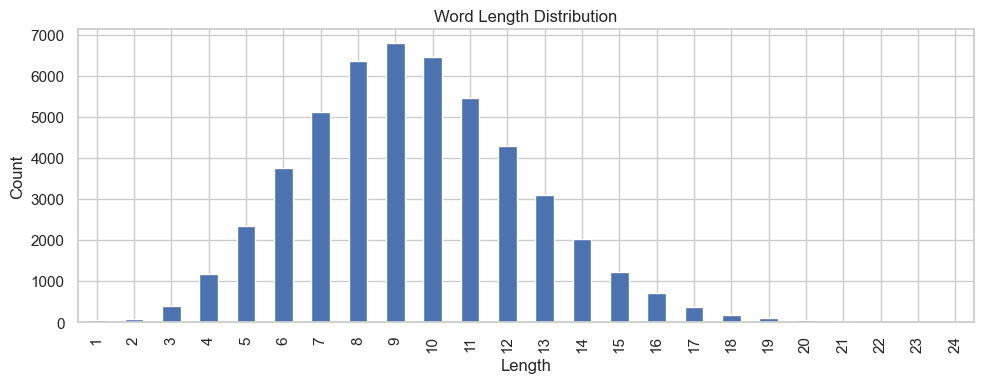

In [5]:
# Word length distribution
plt.figure(figsize=(10,4))
lengths.value_counts().sort_index().plot(kind='bar', color='#4C72B0')
plt.title('Word Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

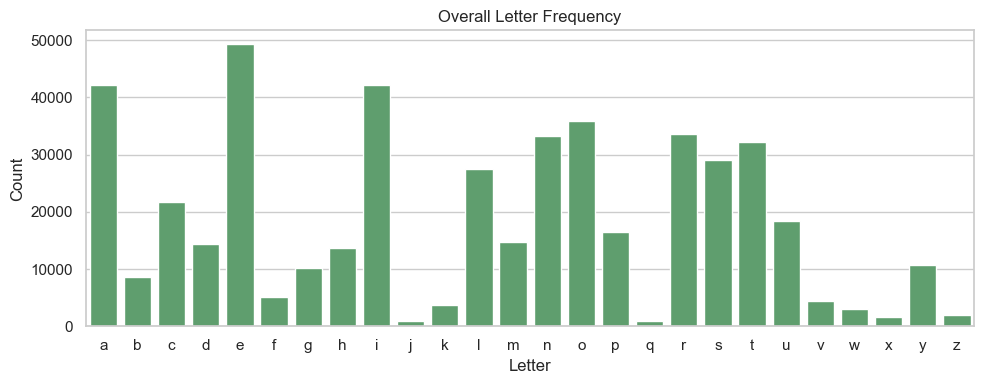

,letter,count
0,a,42110
1,b,8533
2,c,21718
3,d,14324
4,e,49224


In [6]:
# Overall letter frequency
letter_counts = Counter()
for w in words:
    letter_counts.update(list(w))

freq_df = pd.DataFrame({
    'letter': list(LETTERS),
    'count': [letter_counts.get(c, 0) for c in LETTERS]
}).sort_values('letter')

plt.figure(figsize=(10,4))
sns.barplot(data=freq_df, x='letter', y='count', color='#55A868')
plt.title('Overall Letter Frequency')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

freq_df.head()

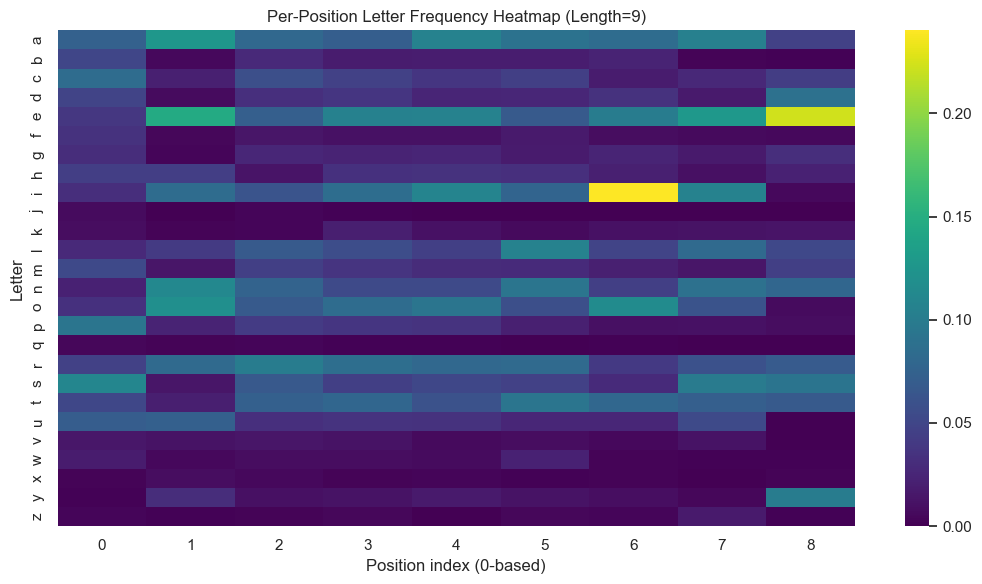

In [7]:
# Per-position letter frequency heatmap for the most common length
common_len = length_counts.idxmax()
subset = [w for w in words if len(w) == common_len]
mat = np.zeros((26, common_len), dtype=np.int64)
for w in subset:
    for i, ch in enumerate(w):
        if ch in LETTER_TO_IDX:
            mat[LETTER_TO_IDX[ch], i] += 1

mat_norm = mat / (mat.sum(axis=0, keepdims=True) + 1e-9)
plt.figure(figsize=(min(16, 1.2*common_len), 6))
sns.heatmap(mat_norm, cmap='viridis', xticklabels=[str(i) for i in range(common_len)], yticklabels=LETTERS)
plt.title(f'Per-Position Letter Frequency Heatmap (Length={common_len})')
plt.xlabel('Position index (0-based)')
plt.ylabel('Letter')
plt.tight_layout()
plt.show()

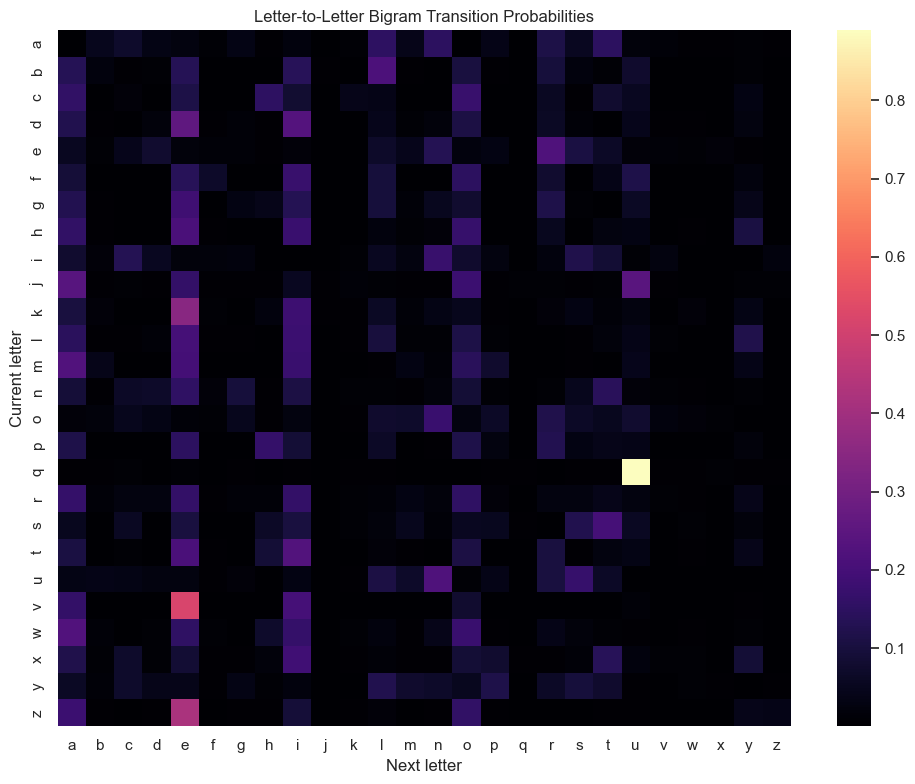

In [8]:
# Bigram (letter-to-letter) transition heatmap
bigram = np.zeros((26, 26), dtype=np.int64)
for w in words:
    for a, b in zip(w, w[1:]):
        if a in LETTER_TO_IDX and b in LETTER_TO_IDX:
            bigram[LETTER_TO_IDX[a], LETTER_TO_IDX[b]] += 1

bigram_prob = bigram / (bigram.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(10,8))
sns.heatmap(bigram_prob, cmap='magma', xticklabels=LETTERS, yticklabels=LETTERS)
plt.title('Letter-to-Letter Bigram Transition Probabilities')
plt.xlabel('Next letter')
plt.ylabel('Current letter')
plt.tight_layout()
plt.show()

In [9]:
# Prepare sequences for HMM (letters 0-25, EOS=26)
seq_indices = []
lengths_seq = []
for w in words:
    obs = [LETTER_TO_IDX[ch] for ch in w if ch in LETTER_TO_IDX]
    obs.append(EOS_IDX)
    seq_indices.extend(obs)
    lengths_seq.append(len(obs))

# Convert to one-hot representation per observation so hmmlearn infers 27 features
X = np.eye(VOCAB_SIZE, dtype=int)[seq_indices]
print(f"Total observations: {X.shape[0]}, total sequences: {len(lengths_seq)}")

Total observations: 524852, total sequences: 50000


In [10]:
# Train a Multinomial HMM
# Choose a reasonable number of hidden states
n_components = 15
model = MultinomialHMM(n_components=n_components, n_iter=50, tol=1e-3, random_state=42, verbose=False)
# Ensure emissionprob_ has 27 columns (a-z + EOS)
model.n_features = VOCAB_SIZE
model.fit(X, lengths=lengths_seq)
print("Trained MultinomialHMM")
print("startprob_:", model.startprob_.shape)
print("transmat_:", model.transmat_.shape)
print("emissionprob_:", model.emissionprob_.shape)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/hmmlearn/_emissions.py:361: RuntimeWarning: divide by zero encountered in matmul
  stats['obs'] += posteriors.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/hmmlearn/_emissions.py:361: RuntimeWarning: overflow encountered in matmul
  stats['obs'] += posteriors.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/hmmlearn/_emissions.py:361: RuntimeWarning: invalid value encountered in matmul
  stats['obs'] += posteriors.T @ X


Trained MultinomialHMM
startprob_: (15,)
transmat_: (15, 15)
emissionprob_: (15, 27)


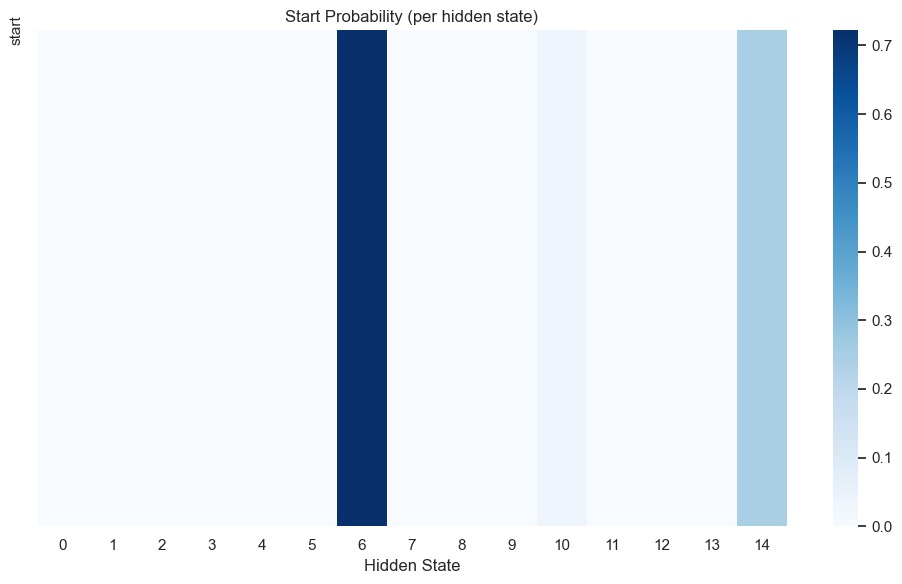

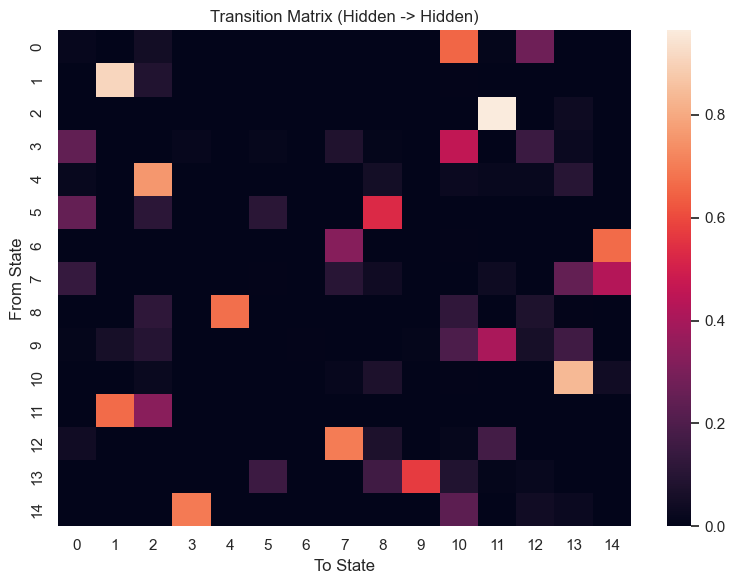

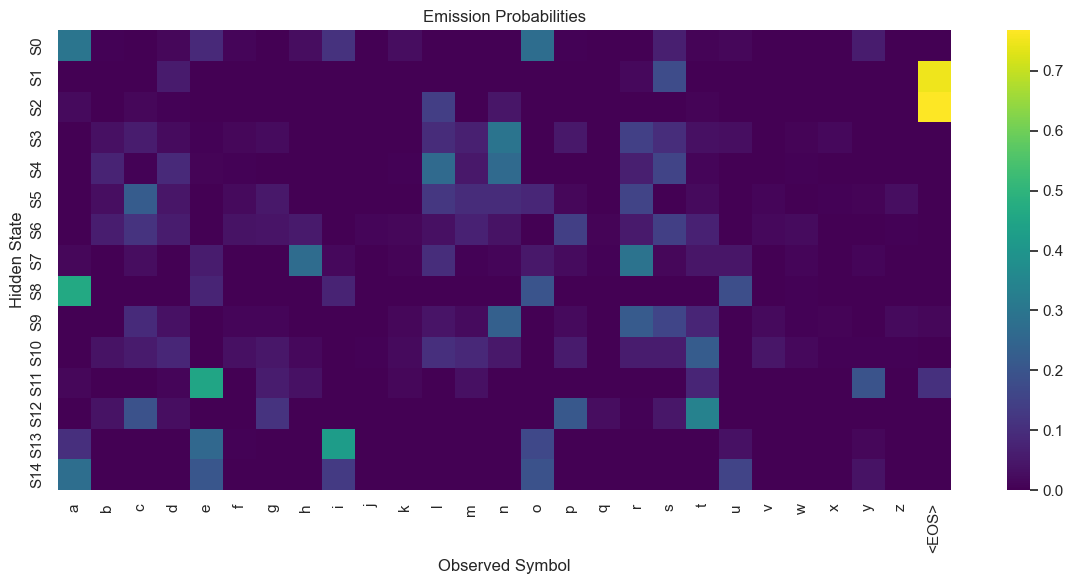

In [11]:
# Visualize HMM parameters
plt.figure(figsize=(10, 6))
sns.heatmap(model.startprob_.reshape(1,-1), cmap='Blues', cbar=True)
plt.title('Start Probability (per hidden state)')
plt.yticks([0],["start"])
plt.xlabel('Hidden State')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(model.transmat_, cmap='rocket', cbar=True)
plt.title('Transition Matrix (Hidden -> Hidden)')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

# Emission probabilities heatmap (states x vocabulary)
plt.figure(figsize=(12, 6))
em_labels = LETTERS + ['<EOS>']
sns.heatmap(model.emissionprob_, cmap='viridis', cbar=True, xticklabels=em_labels, yticklabels=[f'S{i}' for i in range(model.n_components)])
plt.title('Emission Probabilities')
plt.xlabel('Observed Symbol')
plt.ylabel('Hidden State')
plt.tight_layout()
plt.show()

In [12]:
# Save HMM artifacts
artifacts_path = "hmm_artifacts.npz"
np.savez_compressed(
    artifacts_path,
    n_components=np.array([model.n_components]),
    startprob=model.startprob_,
    transmat=model.transmat_,
    emissionprob=model.emissionprob_,
    vocab=np.array(VOCAB, dtype=object)
)
print(f"Saved HMM artifacts to {artifacts_path}")

Saved HMM artifacts to hmm_artifacts.npz


In [13]:
# HMM-based letter oracle

def forward_state_probs(mask: str, startprob, transmat, emissionprob):
    L = len(mask)
    alphas = []
    # process first position
    if L == 0:
        return []
    # position 0
    alpha = startprob.copy()
    ch0 = mask[0]
    if ch0 != '_' and ch0 in LETTER_TO_IDX:
        alpha = alpha * emissionprob[:, LETTER_TO_IDX[ch0]]
    alpha = alpha / (alpha.sum() + 1e-12)
    alphas.append(alpha)
    # subsequent positions
    for i in range(1, L):
        alpha = alpha @ transmat
        chi = mask[i]
        if chi != '_' and chi in LETTER_TO_IDX:
            alpha = alpha * emissionprob[:, LETTER_TO_IDX[chi]]
        alpha = alpha / (alpha.sum() + 1e-12)
        alphas.append(alpha)
    return alphas


def hmm_letter_oracle(mask: str, guessed: set[str], startprob=None, transmat=None, emissionprob=None):
    if startprob is None:
        startprob = model.startprob_
    if transmat is None:
        transmat = model.transmat_
    if emissionprob is None:
        emissionprob = model.emissionprob_

    mask = mask.lower()
    alphas = forward_state_probs(mask, startprob, transmat, emissionprob)
    if not alphas:
        return {c: 1.0/26 for c in LETTERS}

    # Aggregate letter distributions for unknown positions
    agg = np.zeros(26)
    unknown_positions = 0
    for i, ch in enumerate(mask):
        if ch == '_':
            unknown_positions += 1
            state_mix = alphas[i]  # shape (n_states,)
            # mixture over emissions
            letter_mix = state_mix @ emissionprob[:, :26]  # exclude EOS column
            agg += letter_mix
    if unknown_positions > 0:
        agg = agg / unknown_positions

    # zero out guessed letters and known letters in mask
    for g in guessed:
        if g in LETTER_TO_IDX:
            agg[LETTER_TO_IDX[g]] = 0.0

    # normalize
    if agg.sum() <= 1e-12:
        # fallback uniform over unguessed
        mask_set = set(ch for ch in mask if ch in LETTER_TO_IDX)
        available = [c for c in LETTERS if c not in guessed]
        if not available:
            return {c: 1.0/26 for c in LETTERS}
        p = 1.0/len(available)
        return {c: (p if c in available else 0.0) for c in LETTERS}
    agg = agg / agg.sum()
    return {IDX_TO_LETTER[i]: agg[i] for i in range(26)}

# Quick demo
sample_mask = "_a__"  # pretend current word has 'a' at index 1
sample_guessed = set('aeiou')
probs = hmm_letter_oracle(sample_mask, sample_guessed)
list(sorted(probs.items(), key=lambda x: -x[1]))[:10]

[('n', np.float64(0.11800945390511428)),
 ('t', np.float64(0.11181799899818777)),
 ('s', np.float64(0.09986050656414912)),
 ('r', np.float64(0.09159522088915105)),
 ('p', np.float64(0.08864064907747844)),
 ('c', np.float64(0.08343638342057821)),
 ('l', np.float64(0.07211661005894938)),
 ('m', np.float64(0.06515099627881533)),
 ('d', np.float64(0.04980806283382538)),
 ('b', np.float64(0.04223026588673094))]